Datasets used: 
- `Subject List Dataset(SSL)` :<br>
The information displayed represents a de-identified listing of arrest data from August 1, 2012 to July 31, 2016, that was used by the Chicago Police Department’s Strategic Subject Algorithm,<br> created by the Illinois Institute of Technology and funded through a Department of Justice Bureau of Justice Assistance grant,<br> to create a risk assessment score known as the Strategic Subject List or “SSL.” <br>These scores reflect an individual’s probability of being involved in a shooting incident either as a victim or an offender.<br> Scores are calculated and placed on a scale ranging from 0 (extremely low risk) to 500 (extremely high risk).

Reference Links: https://data.cityofchicago.org/Public-Safety/Strategic-Subject-List-Historical/4aki-r3np

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
from aif360.sklearn.datasets import fetch_adult
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
sensitive_attribute = "SEX CODE CD"

## Load Dataset

In [3]:
urlfile= "https://raw.githubusercontent.com/samuel-yeom/fliptest/master/exact-ot/chicago-ssl-clean.csv"

X = pd.read_csv(urlfile)
num_features = X._get_numeric_data().columns.to_list()

#Values >= 345 (High Risk) are considered unfavorable
X['SSL SCORE'] = np.where((X['SSL SCORE'] >= 345) , 0, 1)

df = X.copy()
cate_features = df.select_dtypes(include=['object']).columns.to_list()

df.head()

,SSL SCORE,PREDICTOR RAT AGE AT LATEST ARREST,PREDICTOR RAT VICTIM SHOOTING INCIDENTS,PREDICTOR RAT VICTIM BATTERY OR ASSAULT,PREDICTOR RAT ARRESTS VIOLENT OFFENSES,PREDICTOR RAT GANG AFFILIATION,PREDICTOR RAT NARCOTIC ARRESTS,PREDICTOR RAT TREND IN CRIMINAL ACTIVITY,PREDICTOR RAT UUW ARRESTS,SEX CODE CD,RACE CODE CD
0,0,20-30,0,1,4,1,1,1.0,1,M,BLK
1,0,20-30,0,9,1,1,0,1.0,0,M,WHI
2,0,less than 20,1,2,1,1,3,1.0,0,M,WHI
3,0,less than 20,1,1,4,1,0,1.6,1,M,BLK
4,0,less than 20,0,0,5,0,0,1.3,3,M,BLK


## Model training and test

In [4]:
X = df.drop('SSL SCORE', axis=1)
y = df['SSL SCORE']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='SSL SCORE')
model.predict(X_test.iloc[:100, :])

Wall time: 21.3 s


array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [6]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.83      0.62      0.71     11432
           1       0.96      0.99      0.97    108143

    accuracy                           0.95    119575
   macro avg       0.90      0.80      0.84    119575
weighted avg       0.95      0.95      0.95    119575



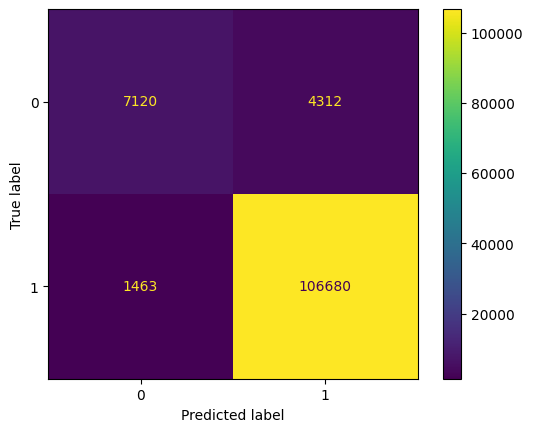

In [7]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [8]:
for col in cate_features:
    X_test[col] = X_test[col].astype('object')

In [8]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
   X_test,
    model=model,
    sensitive_attribute='SEX CODE CD',
    missing_subgroup_val="X"
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████| 2/2 [00:08<00:00,  4.28s/it]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████| 5357/5357 [01:27<00:00, 61.53it/s]

Computing correctenesses for all valid if-thens.



100%|██████████| 12740/12740 [03:55<00:00, 54.02it/s]


Number of if-thens: 12740


In [8]:
#### Uncomment if you wish to load rules object from disk

import dill

with open("rulesSSL.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [9]:
#### Uncomment if you wish to save rules object on disk

import dill

with open("rulesSSL.data", "wb") as outf:
     dill.dump(rules_by_if, outf)

In [9]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["M"][1][0][1]-e[1]["F"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.8:
	Subgroup 'F', 1.00% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 83.33%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.2 with correctness 58.33%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.6 with correctness 8.33%.
	Subgroup 'M', 1.07% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 30.38%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.2 with correctness 20.25%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.6 with correctness 0.00%.
If PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.8:
	Subgroup 'F', 1.00% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 83.33%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.2 with c

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [10]:
feature_weights = {"SEX CODE CD": 1, "RACE CODE CD": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [11]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (X["SEX CODE CD"] == sg).sum() for sg in X["SEX CODE CD"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1, PREDICTOR RAT AGE AT LATEST ARREST = 20-30, RACE CODE CD = BLK, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3:
	Subgroup 'F', 2.92% covered out of 96295
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT AGE AT LATEST ARREST = less than 20, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 74.29%.
		Aggregate cost of the above recourses = -2.23
	Subgroup 'M', 1.00% covered out of 302230
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT AGE AT LATEST ARREST = less than 20, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 29.73%.
		Aggregate cost of the above recourses = -0.89
	Bias against M. Unfairness measure = 1.34.
If PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0:
	Subgroup 'F', 2.17% covered out of 96295
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAU

## Minimum cost above threshold

In [12]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
    secondary_sorting=True
)

pop_sizes = {sg: (X["SEX CODE CD"] == sg).sum() for sg in X["SEX CODE CD"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, RACE CODE CD = BLK, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Subgroup 'F', 41.42% covered out of 96295
		Make RACE CODE CD = WHI with correctness 53.32%.
		Aggregate cost of the above recourses = 1.00
	Subgroup 'M', 20.66% covered out of 302230
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Bias against M. Unfairness measure = inf.
If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT AGE AT LATEST ARREST = less than 20, RACE CODE CD = BLK:
	Subgroup 'F', 34.83% covered out of 96295
		Make RACE CODE CD = WHI with correctness 51.91%.
		Aggregate cost of the above recourses = 1.00
	Subgroup 'M', 20.52% covered out of 302230
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Bias against M. Unfairness measure = inf.
If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, RACE CODE CD = BLK, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0:
	Subgr

## Mean cost above threshold

In [13]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["SEX CODE CD"] == sg).sum() for sg in X["SEX CODE CD"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs
))

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, RACE CODE CD = BLK, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Subgroup 'F', 41.42% covered out of 96295
		Make RACE CODE CD = WHI with correctness 53.32%.
	Subgroup 'M', 20.66% covered out of 302230
		No recourses for this subgroup!
	Bias against M. Unfairness measure = inf.
If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT AGE AT LATEST ARREST = less than 20, RACE CODE CD = BLK:
	Subgroup 'F', 34.83% covered out of 96295
		Make RACE CODE CD = WHI with correctness 51.91%.
	Subgroup 'M', 20.52% covered out of 302230
		No recourses for this subgroup!
	Bias against M. Unfairness measure = inf.
If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, RACE CODE CD = BLK, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0:
	Subgroup 'F', 28.42% covered out of 96295
		No recourses for this subgroup!
	Subgroup 'M', 7.53% covered out of 302230
		Make RACE CODE CD = WHI with correctness 55.50%.
	Bias against F. Unfa

## Number above threshold

In [14]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["SEX CODE CD"] == sg).sum() for sg in X["SEX CODE CD"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, PREDICTOR RAT GANG AFFILIATION = 1:
	Subgroup 'F', 1.00% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, PREDICTOR RAT GANG AFFILIATION = 0 with correctness 66.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, PREDICTOR RAT GANG AFFILIATION = 0 with correctness 66.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, PREDICTOR RAT GANG AFFILIATION = 0 with correctness 66.67%.
		Make PREDICTOR RAT GANG AFFILIATION = 0 with correctness 66.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.0, PREDICTOR RAT GANG AFFILIATION = 0 with correctness 66.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.2, PREDICTOR RAT GANG AFFILIATION = 0 with correctness 66.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.2, PREDICTOR RAT GANG AFFILIATION = 0 with correctness 66.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.4, PREDICTOR RAT GANG AFFILIATION = 0 with correctness 75.

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [18]:
import dill

with open("stateSSL.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, PREDICTOR RAT GANG AFFILIATION = 1:
	Subgroup 'F', 1.00% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, PREDICTOR RAT GANG AFFILIATION = 0 with correctness 66.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1, PREDICTOR RAT GANG AFFILIATION = 0 with correctness 66.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, PREDICTOR RAT GANG AFFILIATION = 0 with correctness 66.67%.
		Make PREDICTOR RAT GANG AFFILIATION = 0 with correctness 66.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.0, PREDICTOR RAT GANG AFFILIATION = 0 with correctness 66.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.2, PREDICTOR RAT GANG AFFILIATION = 0 with correctness 66.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.2, PREDICTOR RAT GANG AFFILIATION = 0 with correctness 66.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.4, PREDICTOR RAT GANG AFFILIATION = 0 with correctness 75.

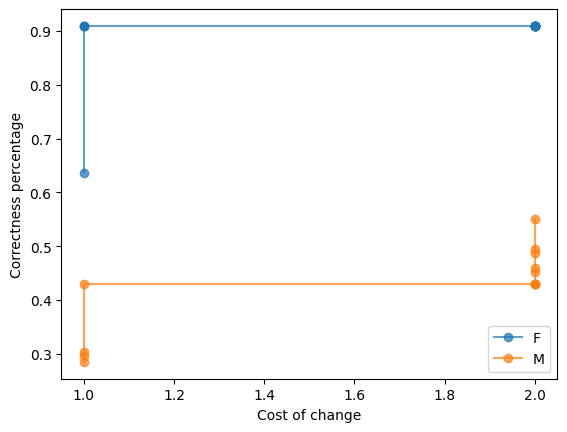

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.4, RACE CODE CD = BLK:
	Subgroup 'F', 9.08% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 69.72%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 56.88%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 45.87%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 71.56%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WHI with correctness 66.97%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WHI with correctness 63.30%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WWH with correctness 55.96%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.0 with correctness 63.30%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.2 with correctness 66.97%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.4 with correctness 69.72%.
		Make PREDIC

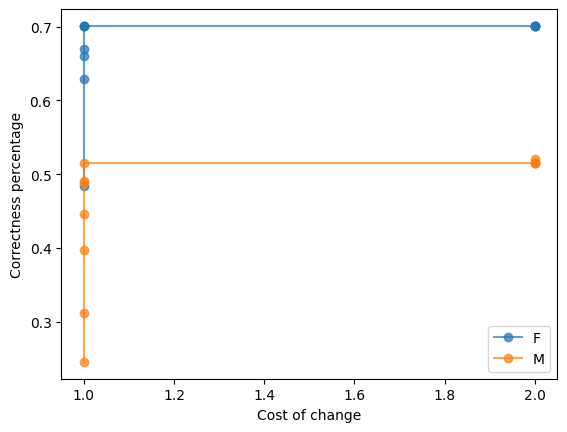

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.4, RACE CODE CD = BLK, PREDICTOR RAT NARCOTIC ARRESTS = 0:
	Subgroup 'F', 7.33% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 69.32%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 69.32%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 55.68%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 70.45%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WWH with correctness 68.18%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WHI with correctness 69.32%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WHI with correctness 69.32%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.0 with correctness 69.32%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.2 with correctness 69.32%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.4 wi

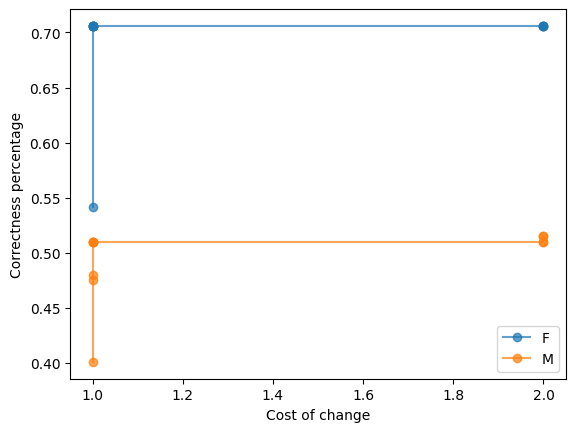

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.7, RACE CODE CD = BLK, PREDICTOR RAT NARCOTIC ARRESTS = 0:
	Subgroup 'F', 2.08% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 68.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 68.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 60.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 68.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WWH with correctness 64.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WHI with correctness 68.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WHI with correctness 68.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.0 with correctness 68.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.2 with correctness 68.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.4 wi

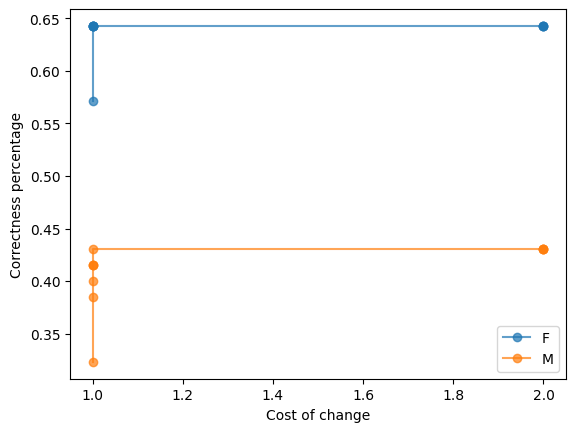

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.9, RACE CODE CD = BLK:
	Subgroup 'F', 1.92% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 69.57%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 65.22%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 43.48%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, RACE CODE CD = WHI with correctness 73.91%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, RACE CODE CD = WHI with correctness 69.57%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WHI with correctness 65.22%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3, RACE CODE CD = WWH with correctness 60.87%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.0 with correctness 65.22%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.2 with correctness 69.57%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.4 with correctness 69.57%.
		Make PREDIC

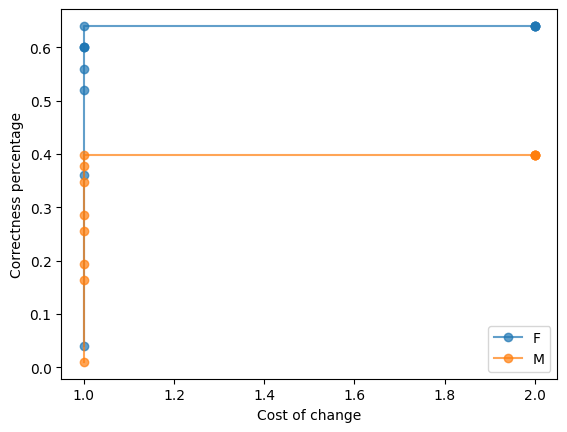

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.4, PREDICTOR RAT NARCOTIC ARRESTS = 0:
	Subgroup 'F', 7.83% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 65.96%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 65.96%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 65.96%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 52.13%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.0 with correctness 65.96%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.2 with correctness 65.96%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, PREDICTOR RAT NARCOTIC ARRESTS = 1 with correctness 65.96%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.2 with correctness 55.32%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.4 with correctness 65.96%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, PREDICTOR RAT NARCOTIC ARRESTS = 1 with correctness 0.00%.
		Mak

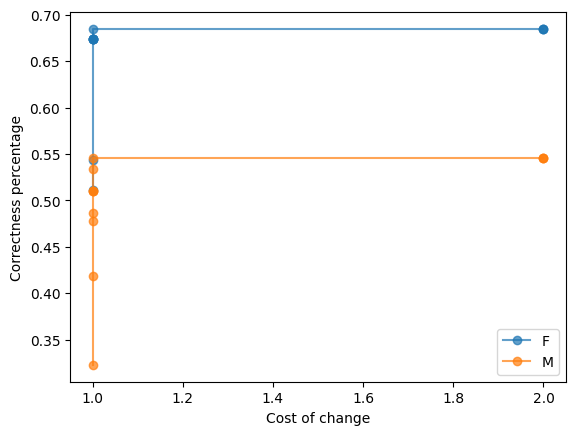

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.5:
	Subgroup 'F', 3.50% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 73.81%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 71.43%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 69.05%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 59.52%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.0 with correctness 71.43%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.2 with correctness 73.81%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.2 with correctness 64.29%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.4 with correctness 73.81%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.6 with correctness 76.19%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.4 with correctness 0.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.6 with correctness 0.00%.
		Make PREDICTOR RAT TREND IN CRIMI

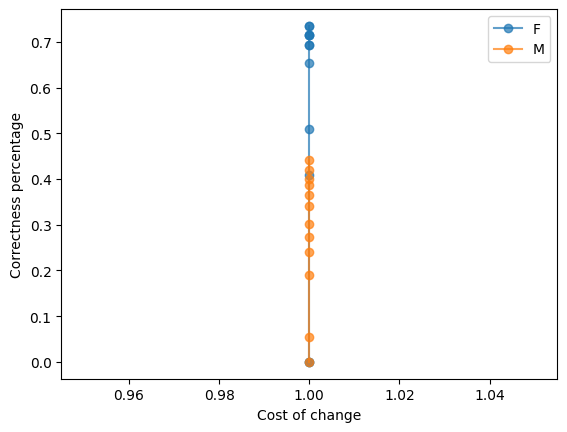

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.5, PREDICTOR RAT GANG AFFILIATION = 0:
	Subgroup 'F', 3.25% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 71.79%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 69.23%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 66.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 64.10%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.0 with correctness 69.23%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.2 with correctness 71.79%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.2 with correctness 66.67%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.4 with correctness 71.79%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.6 with correctness 74.36%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, PREDICTOR RAT GANG AFFILIATION = 1 with correctness 69.23%.
		Make PREDICTOR RAT TREND IN CRIMINAL 

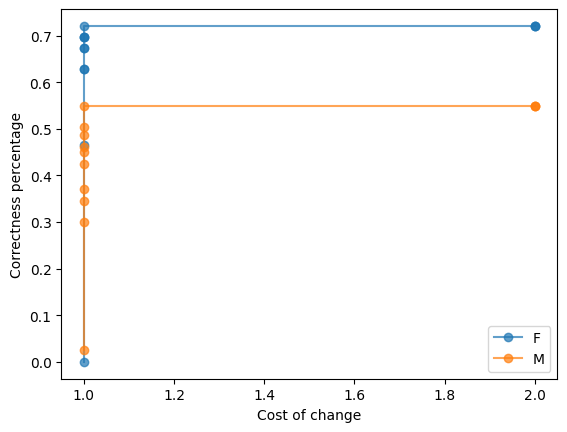

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.8:
	Subgroup 'F', 1.67% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 75.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 75.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 65.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 45.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.0 with correctness 75.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.2 with correctness 75.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.2 with correctness 50.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.4 with correctness 75.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.6 with correctness 75.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.4 with correctness 25.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.6 with correctness 10.00%.
		Make PREDICTOR RAT TREND IN CRI

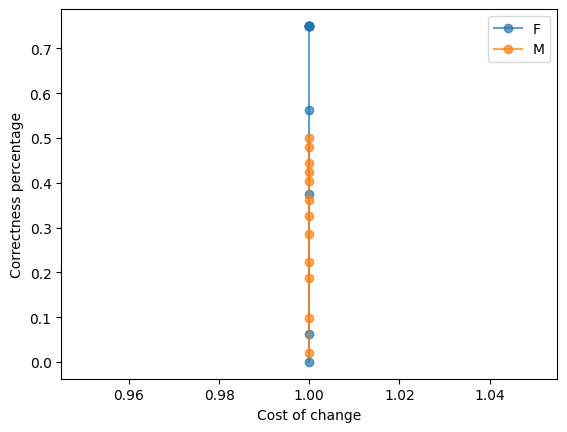

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.5, PREDICTOR RAT NARCOTIC ARRESTS = 0:
	Subgroup 'F', 3.08% covered out of 96295
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3 with correctness 75.68%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.1 with correctness 75.68%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1 with correctness 75.68%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.3 with correctness 67.57%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.0 with correctness 75.68%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.2 with correctness 75.68%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.3, PREDICTOR RAT NARCOTIC ARRESTS = 1 with correctness 75.68%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.2 with correctness 72.97%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = -0.4 with correctness 75.68%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 0.1, PREDICTOR RAT NARCOTIC ARRESTS = 1 with correctness 0.00%.
		Mak

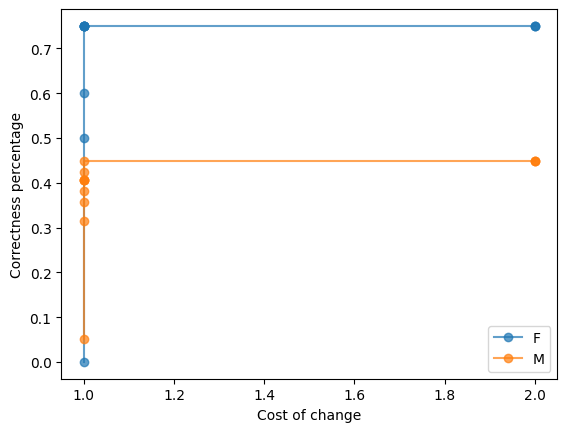

In [15]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    # filter_sequence=["remove-below-thr"]
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="SEX CODE CD")

pop_sizes = {sg: (X["SEX CODE CD"] == sg).sum() for sg in X["SEX CODE CD"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [17]:
import dill

with open("stateSSL.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)